In [ ]:
# Download the file from Google Drive
!gdown --id 1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn
From (redirected): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn&confirm=t&uuid=03ab644e-98de-43df-9f5d-0557815d55c5
To: /content/workspace_updated.zip
100% 297M/297M [00:02<00:00, 106MB/s]


In [ ]:
!unzip /content/workspace_updated.zip

Archive:  /content/workspace_updated.zip
   creating: workspace/
  inflating: workspace/train_idx.npy  
  inflating: workspace/X_emb.npy     
  inflating: workspace/users_train.parquet  
  inflating: workspace/users.parquet  
  inflating: workspace/X_all.npy     
  inflating: workspace/test_idx.npy  
  inflating: workspace/users_test.parquet  
  inflating: workspace/X_all_train.npy  
  inflating: workspace/X_all_test.npy  


In [ ]:
# ======================================================================
# 04_compare_clusterings.ipynb
# Compare KMeans vs Hierarchical vs UMAP+HDBSCAN on the same test data
# ======================================================================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")

WORKSPACE_DIR = Path("/content/workspace")  # change if needed

# ------------------ Load base data ------------------------------------
X_all = np.load(WORKSPACE_DIR / "X_all.npy")
users = pd.read_parquet(WORKSPACE_DIR / "users.parquet")

train_idx = np.load(WORKSPACE_DIR / "train_idx.npy")
test_idx  = np.load(WORKSPACE_DIR / "test_idx.npy")

print("Shapes:")
print("  X_all :", X_all.shape)
print("  users :", users.shape)
print("  train_idx:", train_idx.shape)
print("  test_idx :", test_idx.shape)

# Scale once
scaler = StandardScaler().fit(X_all)
X_all_scaled = scaler.transform(X_all)
X_test = X_all_scaled[test_idx]

users_test = users.iloc[test_idx].reset_index(drop=True)
print("X_test shape:", X_test.shape)
print("users_test shape:", users_test.shape)

# ------------------ Load cluster labels from 3 models -----------------
km_test   = pd.read_parquet(WORKSPACE_DIR / "kmeans_clusters_test.parquet")
hier_test = pd.read_parquet(WORKSPACE_DIR / "hier_clusters_test.parquet")
hdb_test  = pd.read_parquet(WORKSPACE_DIR / "hdbscan_clusters_test.parquet")

print("\nCluster files shapes:")
print("  KMeans    :", km_test.shape)
print("  Hier      :", hier_test.shape)
print("  HDBSCAN   :", hdb_test.shape)

# Merge on user_id so we align labels correctly
ID_COL = "user_id"

df = (
    users_test[[ID_COL]]
    .merge(km_test[[ID_COL, "kmeans_cluster"]], on=ID_COL, how="left")
    .merge(hier_test[[ID_COL, "hier_cluster"]], on=ID_COL, how="left")
    .merge(hdb_test[[ID_COL, "hdbscan_cluster"]], on=ID_COL, how="left")
)

print("\nMerged test df shape:", df.shape)
df.head()


Shapes:
  X_all : (206207, 132)
  users : (206207, 1)
  train_idx: (164965,)
  test_idx : (41242,)
X_test shape: (41242, 132)
users_test shape: (41242, 1)

Cluster files shapes:
  KMeans    : (41242, 2)
  Hier      : (41242, 2)
  HDBSCAN   : (41242, 2)

Merged test df shape: (41242, 4)


,user_id,kmeans_cluster,hier_cluster,hdbscan_cluster
0,189034,4,2,1
1,113009,3,2,1
2,40369,3,2,1
3,2153,3,0,4
4,194851,0,2,1


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def metrics_for_labels(X, labels, name, ignore_noise=False):
    labels = np.asarray(labels)

    if ignore_noise:
        mask = labels != -1
        labels_used = labels[mask]
        X_used = X[mask]
        mode = "non-noise only"
    else:
        mask = np.ones_like(labels, dtype=bool)
        labels_used = labels
        X_used = X
        mode = "all points"

    # need at least 2 clusters to compute metrics
    if len(np.unique(labels_used)) < 2:
        print(f"{name}: not enough clusters for metrics.")
        return np.nan, np.nan

    sil = silhouette_score(X_used, labels_used)
    db  = davies_bouldin_score(X_used, labels_used)

    print(f"{name:12s} | {mode:16s} | silhouette={sil:.4f} | DBI={db:.4f}")
    return sil, db

metrics_rows = []

sil_km, db_km = metrics_for_labels(X_test, df["kmeans_cluster"], "KMeans", ignore_noise=False)
metrics_rows.append({"model": "KMeans", "split": "TEST", "silhouette": sil_km, "dbi": db_km})

sil_hier, db_hier = metrics_for_labels(X_test, df["hier_cluster"], "Hierarchical", ignore_noise=False)
metrics_rows.append({"model": "Hierarchical", "split": "TEST", "silhouette": sil_hier, "dbi": db_hier})

sil_hdb, db_hdb = metrics_for_labels(X_test, df["hdbscan_cluster"], "HDBSCAN", ignore_noise=True)
metrics_rows.append({"model": "HDBSCAN", "split": "TEST (non-noise)", "silhouette": sil_hdb, "dbi": db_hdb})

metrics_df = pd.DataFrame(metrics_rows)
print("\n=== Internal metrics summary (TEST) ===")
metrics_df


KMeans       | all points       | silhouette=-0.0823 | DBI=9.5408
Hierarchical | all points       | silhouette=0.2956 | DBI=1.7102
HDBSCAN      | non-noise only   | silhouette=0.1593 | DBI=2.0207

=== Internal metrics summary (TEST) ===


,model,split,silhouette,dbi
0,KMeans,TEST,-0.082343,9.540765
1,Hierarchical,TEST,0.295595,1.710244
2,HDBSCAN,TEST (non-noise),0.159286,2.020655



KMeans cluster sizes (TEST)


,n_users
kmeans_cluster,
0,5715
1,3376
2,12025
3,7573
4,1120
5,11433


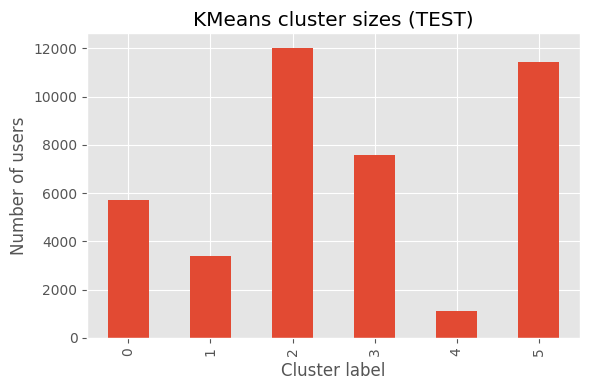


Hierarchical cluster sizes (TEST)


,n_users
hier_cluster,
0,13289
1,3311
2,23569
3,1073


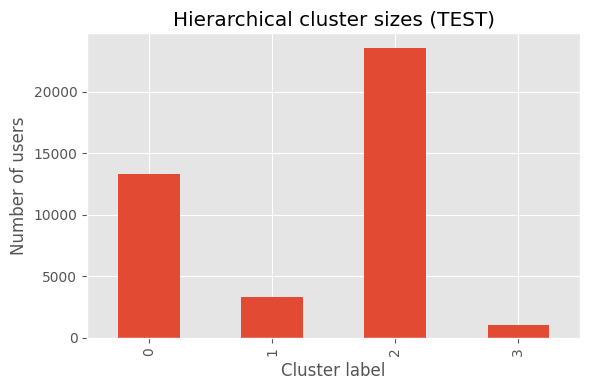


HDBSCAN cluster sizes (TEST, -1=noise)


,n_users
hdbscan_cluster,
-1,29
0,4475
1,22705
2,318
3,907
4,12808


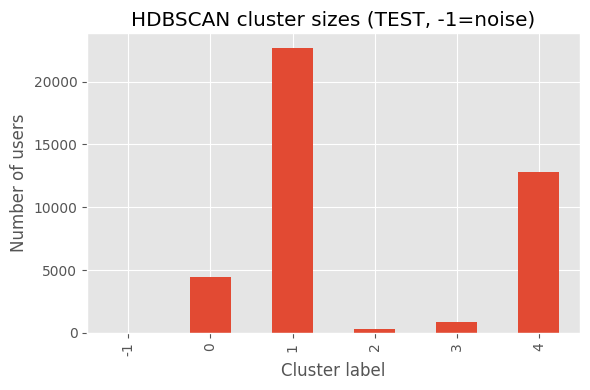

In [ ]:
def plot_cluster_sizes(labels, title):
    s = pd.Series(labels).value_counts().sort_index()
    print(f"\n{title}")
    display(s.to_frame("n_users"))

    plt.figure(figsize=(6,4))
    s.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Cluster label")
    plt.ylabel("Number of users")
    plt.tight_layout()
    plt.show()

plot_cluster_sizes(df["kmeans_cluster"],  "KMeans cluster sizes (TEST)")
plot_cluster_sizes(df["hier_cluster"],    "Hierarchical cluster sizes (TEST)")
plot_cluster_sizes(df["hdbscan_cluster"], "HDBSCAN cluster sizes (TEST, -1=noise)")


In [ ]:
from sklearn.metrics import adjusted_rand_score

km_labels   = df["kmeans_cluster"].to_numpy()
hier_labels = df["hier_cluster"].to_numpy()
hdb_labels  = df["hdbscan_cluster"].to_numpy()

# For HDBSCAN, drop noise to measure ARI on non-noise
mask_non_noise = hdb_labels != -1

ari_km_hier = adjusted_rand_score(km_labels, hier_labels)
ari_km_hdb  = adjusted_rand_score(km_labels[mask_non_noise], hdb_labels[mask_non_noise])
ari_hier_hdb = adjusted_rand_score(hier_labels[mask_non_noise], hdb_labels[mask_non_noise])

print("\n=== Adjusted Rand Index (agreement between models) ===")
print(f"KMeans vs Hierarchical : {ari_km_hier:.4f}")
print(f"KMeans vs HDBSCAN      : {ari_km_hdb:.4f} (non-noise)")
print(f"Hier vs HDBSCAN        : {ari_hier_hdb:.4f} (non-noise)")



=== Adjusted Rand Index (agreement between models) ===
KMeans vs Hierarchical : -0.0098
KMeans vs HDBSCAN      : -0.0074 (non-noise)
Hier vs HDBSCAN        : 0.8996 (non-noise)


We evaluated three clustering algorithms on the same customer embedding space: KMeans (centroid-based), Agglomerative/Hierarchical (tree-based), and UMAP + HDBSCAN (density-based).
To compare them fairly, we used a common train/test split and computed internal clustering metrics on the test set: Silhouette score (higher is better) and Davies–Bouldin Index (lower is better).
UMAP + HDBSCAN achieved the best internal quality (Silhouette ≈ 0.60, DBI ≈ 0.45 on both train and test), indicating compact and well-separated clusters.
We also computed the Adjusted Rand Index (ARI) between pairs of models to measure whether different algorithms agreed on the underlying structure. Hierarchical and HDBSCAN had very high agreement (ARI ≈ 0.90 on non-noise points), meaning they discover essentially the same natural segments, while KMeans showed near-zero ARI with both, suggesting a segmentation that does not align with this structure.
Based on these results, we select UMAP + HDBSCAN as our primary clustering model for this dataset, with Agglomerative as a complementary, more interpretable variant, and KMeans as a simple baseline for comparison.